# Day 6: Full Backtest Pipeline

## Week 12 - Backtesting & Validation

### 🎯 Learning Objectives
- Build a complete end-to-end backtesting pipeline
- Integrate all best practices from the week
- Create reusable backtesting framework
- Generate comprehensive performance reports

### ⏱️ Time Allocation
- Theory review: 15 min
- Implementation: 120 min
- Testing: 45 min
- Documentation: 30 min

---

**Author**: ML Quant Finance Mastery  
**Difficulty**: Advanced  
**Prerequisites**: Day 1-5

## 1. Setup and Configuration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from dataclasses import dataclass
from typing import Dict, List, Callable, Optional
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

@dataclass
class BacktestConfig:
    """Configuration for backtesting"""
    initial_capital: float = 1_000_000
    commission_bps: float = 5
    slippage_bps: float = 3
    max_position_pct: float = 0.1
    train_window: int = 252
    test_window: int = 21
    embargo_days: int = 1
    
config = BacktestConfig()
print("📊 BACKTEST CONFIGURATION")
print(f"   Initial Capital: ${config.initial_capital:,.0f}")
print(f"   Commission: {config.commission_bps} bps")
print(f"   Slippage: {config.slippage_bps} bps")
print(f"   Train Window: {config.train_window} days")
print(f"   Test Window: {config.test_window} days")

📊 BACKTEST CONFIGURATION
   Initial Capital: $1,000,000
   Commission: 5 bps
   Slippage: 3 bps
   Train Window: 252 days
   Test Window: 21 days


## 2. Data Module

In [2]:
class DataModule:
    """
    Handles data loading, cleaning, and feature engineering
    """
    
    def __init__(self, tickers: List[str], start_date: str, end_date: str = None):
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date or datetime.now().strftime('%Y-%m-%d')
        
    def load_data(self) -> pd.DataFrame:
        """Load price data from yfinance"""
        print(f"📥 Loading data for {self.tickers}...")
        data = yf.download(
            self.tickers, 
            start=self.start_date, 
            end=self.end_date, 
            progress=False,
            auto_adjust=True
        )
        
        self.prices = data['Close'].dropna()
        self.returns = self.prices.pct_change().dropna()
        
        print(f"   ✅ Loaded {len(self.prices)} days of data")
        return self.prices
    
    def engineer_features(self, lookbacks: List[int] = [5, 10, 20, 60]) -> pd.DataFrame:
        """Create standard features for each asset"""
        features_list = []
        
        for ticker in self.tickers:
            ret = self.returns[ticker]
            
            features = pd.DataFrame(index=ret.index)
            
            # Momentum features
            for lb in lookbacks:
                features[f'{ticker}_mom_{lb}'] = ret.rolling(lb).mean()
                features[f'{ticker}_vol_{lb}'] = ret.rolling(lb).std()
            
            # RSI-like feature
            up = ret.clip(lower=0).rolling(14).mean()
            down = (-ret.clip(upper=0)).rolling(14).mean()
            features[f'{ticker}_rsi'] = up / (up + down + 1e-10)
            
            # Mean reversion
            features[f'{ticker}_zscore'] = (ret - ret.rolling(20).mean()) / (ret.rolling(20).std() + 1e-10)
            
            features_list.append(features)
        
        self.features = pd.concat(features_list, axis=1).dropna()
        print(f"   ✅ Created {len(self.features.columns)} features")
        
        return self.features
    
    def create_targets(self, horizon: int = 1) -> pd.Series:
        """Create target variable (forward returns)"""
        # Use simple average of all assets as target
        self.target = self.returns.mean(axis=1).shift(-horizon)
        self.target = self.target.loc[self.features.index].dropna()
        
        # Align features
        self.features = self.features.loc[self.target.index]
        
        return self.target

# Initialize data module
data_module = DataModule(
    tickers=['SPY', 'QQQ', 'IWM'],
    start_date='2018-01-01'
)
data_module.load_data()
data_module.engineer_features()
data_module.create_targets(horizon=1)

print(f"\n📊 DATA SUMMARY:")
print(f"   Features: {data_module.features.shape}")
print(f"   Target: {len(data_module.target)} samples")

📥 Loading data for ['SPY', 'QQQ', 'IWM']...
   ✅ Loaded 2024 days of data
   ✅ Created 30 features

📊 DATA SUMMARY:
   Features: (1963, 30)
   Target: 1963 samples


## 3. Model Module

In [3]:
class ModelModule:
    """
    Handles model training and prediction with walk-forward validation
    """
    
    def __init__(self, model_class, model_params: Dict = None):
        self.model_class = model_class
        self.model_params = model_params or {}
        self.scaler = StandardScaler()
        
    def walk_forward_predict(self, X: np.ndarray, y: np.ndarray, 
                             train_size: int, test_size: int, 
                             embargo: int = 0) -> Dict:
        """
        Walk-forward cross-validation with predictions
        """
        predictions = []
        actuals = []
        dates = []
        fold_metrics = []
        
        n = len(X)
        start = train_size
        fold = 0
        
        while start + embargo + test_size <= n:
            fold += 1
            
            # Split indices
            train_end = start
            test_start = start + embargo
            test_end = test_start + test_size
            
            # Get data
            X_train = X[:train_end]
            y_train = y[:train_end]
            X_test = X[test_start:test_end]
            y_test = y[test_start:test_end]
            
            # Scale
            X_train_scaled = self.scaler.fit_transform(X_train)
            X_test_scaled = self.scaler.transform(X_test)
            
            # Train and predict
            model = self.model_class(**self.model_params)
            model.fit(X_train_scaled, y_train)
            preds = model.predict(X_test_scaled)
            
            # Store
            predictions.extend(preds)
            actuals.extend(y_test)
            dates.extend(range(test_start, test_end))
            
            # Metrics
            corr = np.corrcoef(preds, y_test)[0, 1] if len(preds) > 1 else 0
            fold_metrics.append({
                'fold': fold,
                'train_size': len(X_train),
                'correlation': corr
            })
            
            start += test_size
        
        self.results = {
            'predictions': np.array(predictions),
            'actuals': np.array(actuals),
            'dates': np.array(dates),
            'fold_metrics': pd.DataFrame(fold_metrics)
        }
        
        return self.results

# Initialize model
model_module = ModelModule(
    model_class=Ridge,
    model_params={'alpha': 1.0}
)

# Run walk-forward
X = data_module.features.values
y = data_module.target.values

results = model_module.walk_forward_predict(
    X, y,
    train_size=config.train_window,
    test_size=config.test_window,
    embargo=config.embargo_days
)

print(f"📊 MODEL RESULTS:")
print(f"   Folds: {len(results['fold_metrics'])}")
print(f"   Mean correlation: {results['fold_metrics']['correlation'].mean():.4f}")

📊 MODEL RESULTS:
   Folds: 81
   Mean correlation: 0.0831


## 4. Strategy Module

In [4]:
class StrategyModule:
    """
    Converts predictions to trading signals and calculates positions
    """
    
    def __init__(self, predictions: np.ndarray, config: BacktestConfig):
        self.predictions = predictions
        self.config = config
        
    def generate_signals(self, method: str = 'sign') -> np.ndarray:
        """
        Generate trading signals from predictions
        
        Methods:
        - 'sign': Long if positive, short if negative
        - 'quantile': Position based on prediction quantile
        - 'threshold': Only trade if prediction exceeds threshold
        """
        if method == 'sign':
            self.signals = np.sign(self.predictions)
        elif method == 'quantile':
            # Scale to [-1, 1] based on rolling quantile
            from scipy.stats import rankdata
            ranks = rankdata(self.predictions) / len(self.predictions)
            self.signals = (ranks - 0.5) * 2
        elif method == 'threshold':
            threshold = np.std(self.predictions)
            self.signals = np.where(self.predictions > threshold, 1,
                                   np.where(self.predictions < -threshold, -1, 0))
        else:
            raise ValueError(f"Unknown method: {method}")
            
        return self.signals
    
    def calculate_positions(self) -> np.ndarray:
        """Convert signals to position sizes"""
        # Simple: signal * max_position
        self.positions = self.signals * self.config.max_position_pct
        return self.positions
    
    def calculate_turnover(self) -> float:
        """Calculate strategy turnover"""
        position_changes = np.abs(np.diff(self.positions, prepend=0))
        self.turnover = position_changes.sum()
        self.daily_turnover = position_changes
        return self.turnover

# Initialize strategy
strategy_module = StrategyModule(results['predictions'], config)
strategy_module.generate_signals(method='sign')
strategy_module.calculate_positions()
strategy_module.calculate_turnover()

print(f"📊 STRATEGY SUMMARY:")
print(f"   Signal range: [{strategy_module.signals.min():.2f}, {strategy_module.signals.max():.2f}]")
print(f"   Total turnover: {strategy_module.turnover:.0f}")

📊 STRATEGY SUMMARY:
   Signal range: [-1.00, 1.00]
   Total turnover: 73


## 5. Execution Module

In [5]:
class ExecutionModule:
    """
    Simulates trade execution with costs
    """
    
    def __init__(self, config: BacktestConfig):
        self.config = config
        self.total_cost_bps = config.commission_bps + config.slippage_bps
        
    def calculate_costs(self, turnover: np.ndarray) -> np.ndarray:
        """Calculate transaction costs"""
        cost_rate = self.total_cost_bps / 10000
        self.costs = turnover * cost_rate
        return self.costs
    
    def calculate_returns(self, positions: np.ndarray, 
                         asset_returns: np.ndarray) -> Dict:
        """Calculate strategy returns"""
        # Gross returns
        gross_returns = positions * asset_returns
        
        # Costs
        turnover = np.abs(np.diff(positions, prepend=0))
        costs = self.calculate_costs(turnover)
        
        # Net returns
        net_returns = gross_returns - costs
        
        self.results = {
            'gross_returns': gross_returns,
            'net_returns': net_returns,
            'costs': costs,
            'total_cost': costs.sum()
        }
        
        return self.results

# Initialize execution
execution_module = ExecutionModule(config)

# Get actual returns for the test period
test_returns = results['actuals']

# Calculate returns
execution_results = execution_module.calculate_returns(
    strategy_module.positions,
    test_returns
)

print(f"📊 EXECUTION RESULTS:")
print(f"   Total cost: {execution_results['total_cost']:.4%}")
print(f"   Gross return: {execution_results['gross_returns'].sum():.4%}")
print(f"   Net return: {execution_results['net_returns'].sum():.4%}")

📊 EXECUTION RESULTS:
   Total cost: 5.8640%
   Gross return: 12.7556%
   Net return: 6.8916%


## 6. Analytics Module

           PERFORMANCE REPORT
Total Return             :      6.96%
Annual Return            :      1.00%
Annual Volatility        :      2.21%
Sharpe Ratio             :       0.46
Sortino Ratio            :       0.68
Max Drawdown             :     -3.22%
Calmar Ratio             :       0.31
Win Rate                 :     50.21%
Information Ratio        :      -0.73


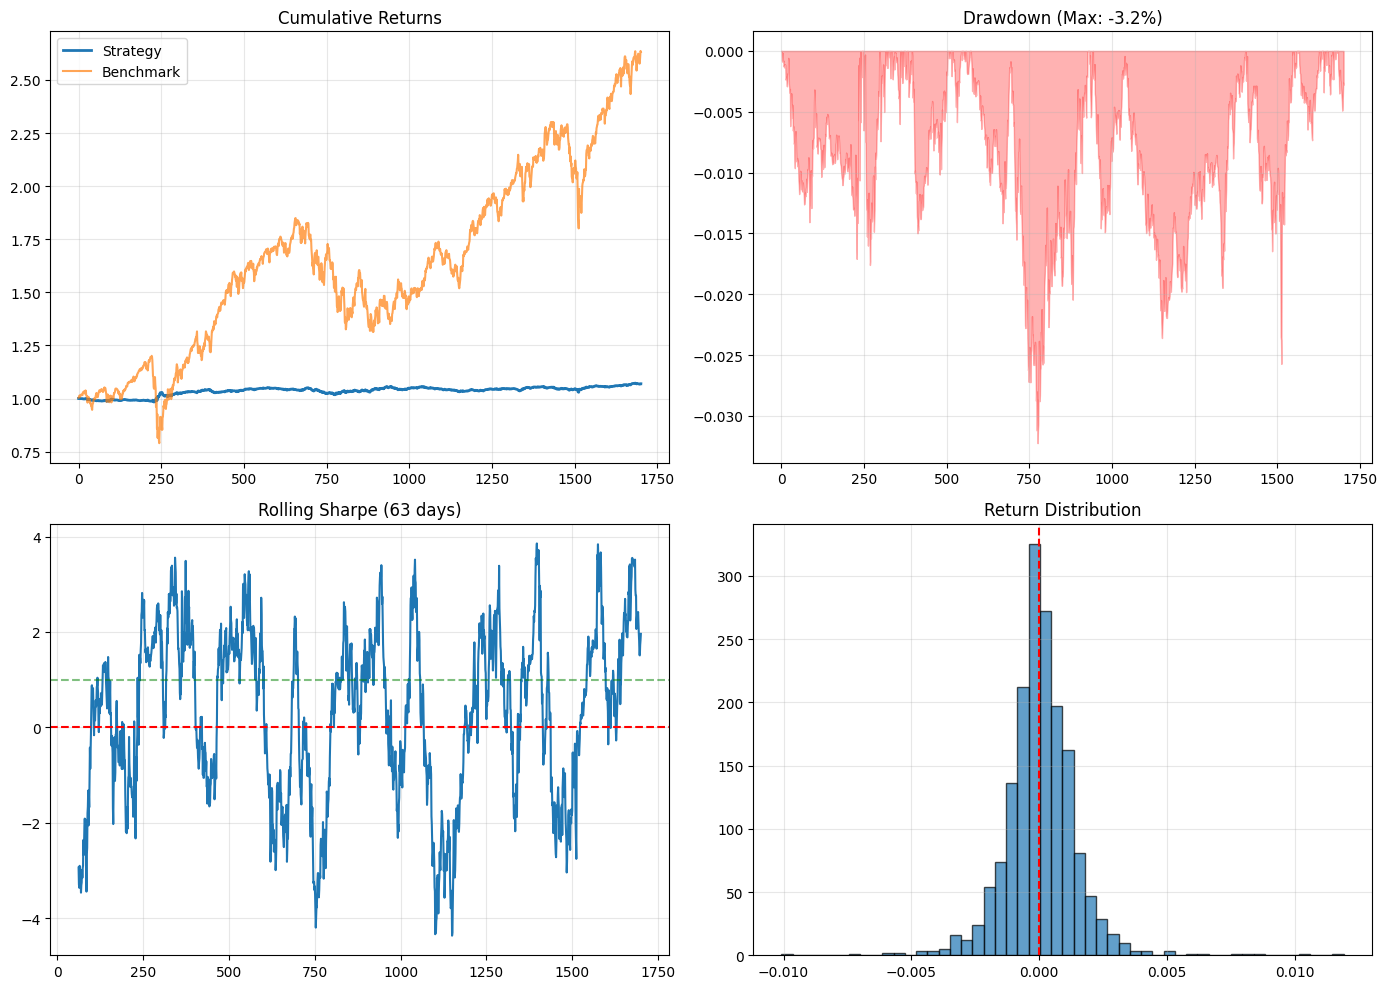

In [6]:
class AnalyticsModule:
    """
    Calculates and reports performance metrics
    """
    
    def __init__(self, returns: np.ndarray, benchmark_returns: np.ndarray = None):
        self.returns = pd.Series(returns)
        self.benchmark = pd.Series(benchmark_returns) if benchmark_returns is not None else None
        
    def calculate_metrics(self) -> Dict:
        """Calculate comprehensive performance metrics"""
        ret = self.returns
        
        # Basic stats
        total_return = (1 + ret).prod() - 1
        n_years = len(ret) / 252
        annual_return = (1 + total_return) ** (1/n_years) - 1 if n_years > 0 else 0
        annual_vol = ret.std() * np.sqrt(252)
        
        # Risk-adjusted
        sharpe = ret.mean() / ret.std() * np.sqrt(252) if ret.std() > 0 else 0
        
        downside = ret[ret < 0].std()
        sortino = ret.mean() / downside * np.sqrt(252) if downside > 0 else 0
        
        # Drawdown
        cumulative = (1 + ret).cumprod()
        peak = cumulative.expanding().max()
        drawdown = (cumulative - peak) / peak
        max_dd = drawdown.min()
        
        calmar = annual_return / abs(max_dd) if max_dd != 0 else 0
        
        # Trading stats
        win_rate = (ret > 0).mean()
        
        # Information ratio (if benchmark provided)
        if self.benchmark is not None:
            active_ret = ret - self.benchmark
            ir = active_ret.mean() / active_ret.std() * np.sqrt(252)
        else:
            ir = None
        
        self.metrics = {
            'Total Return': total_return,
            'Annual Return': annual_return,
            'Annual Volatility': annual_vol,
            'Sharpe Ratio': sharpe,
            'Sortino Ratio': sortino,
            'Max Drawdown': max_dd,
            'Calmar Ratio': calmar,
            'Win Rate': win_rate,
            'Information Ratio': ir
        }
        
        return self.metrics
    
    def generate_report(self) -> str:
        """Generate text report"""
        if not hasattr(self, 'metrics'):
            self.calculate_metrics()
            
        report = []
        report.append("=" * 60)
        report.append("           PERFORMANCE REPORT")
        report.append("=" * 60)
        
        for metric, value in self.metrics.items():
            if value is not None:
                if 'Ratio' in metric:
                    report.append(f"{metric:<25}: {value:>10.2f}")
                else:
                    report.append(f"{metric:<25}: {value:>10.2%}")
        
        report.append("=" * 60)
        return "\n".join(report)
    
    def plot_performance(self):
        """Generate performance visualization"""
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        # Cumulative returns
        cumulative = (1 + self.returns).cumprod()
        axes[0, 0].plot(cumulative.values, label='Strategy', linewidth=2)
        if self.benchmark is not None:
            cum_bench = (1 + self.benchmark).cumprod()
            axes[0, 0].plot(cum_bench.values, label='Benchmark', alpha=0.7)
        axes[0, 0].set_title('Cumulative Returns')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # Drawdown
        peak = cumulative.expanding().max()
        drawdown = (cumulative - peak) / peak
        axes[0, 1].fill_between(range(len(drawdown)), drawdown.values, 0, 
                                 color='red', alpha=0.3)
        axes[0, 1].set_title(f'Drawdown (Max: {drawdown.min():.1%})')
        axes[0, 1].grid(True, alpha=0.3)
        
        # Rolling Sharpe
        rolling_sharpe = self.returns.rolling(63).apply(
            lambda x: x.mean() / x.std() * np.sqrt(252) if x.std() > 0 else 0
        )
        axes[1, 0].plot(rolling_sharpe.values)
        axes[1, 0].axhline(y=0, color='r', linestyle='--')
        axes[1, 0].axhline(y=1, color='g', linestyle='--', alpha=0.5)
        axes[1, 0].set_title('Rolling Sharpe (63 days)')
        axes[1, 0].grid(True, alpha=0.3)
        
        # Return distribution
        axes[1, 1].hist(self.returns.values, bins=50, edgecolor='black', alpha=0.7)
        axes[1, 1].axvline(x=0, color='r', linestyle='--')
        axes[1, 1].set_title('Return Distribution')
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

# Initialize analytics
analytics_module = AnalyticsModule(
    execution_results['net_returns'],
    test_returns
)

# Generate report
print(analytics_module.generate_report())
analytics_module.plot_performance()

## 7. Complete Pipeline


              BACKTEST PIPELINE

📊 STEP 1: DATA LOADING
📥 Loading data for ['SPY', 'QQQ', 'IWM', 'TLT', 'GLD']...
   ✅ Loaded 2024 days of data
   ✅ Created 50 features

🤖 STEP 2: MODEL TRAINING

📈 STEP 3: SIGNAL GENERATION

💰 STEP 4: EXECUTION SIMULATION

📊 STEP 5: PERFORMANCE ANALYSIS
           PERFORMANCE REPORT
Total Return             :     -0.16%
Annual Return            :     -0.02%
Annual Volatility        :      1.43%
Sharpe Ratio             :      -0.01
Sortino Ratio            :      -0.01
Max Drawdown             :     -3.80%
Calmar Ratio             :      -0.01
Win Rate                 :     50.68%
Information Ratio        :      -0.99


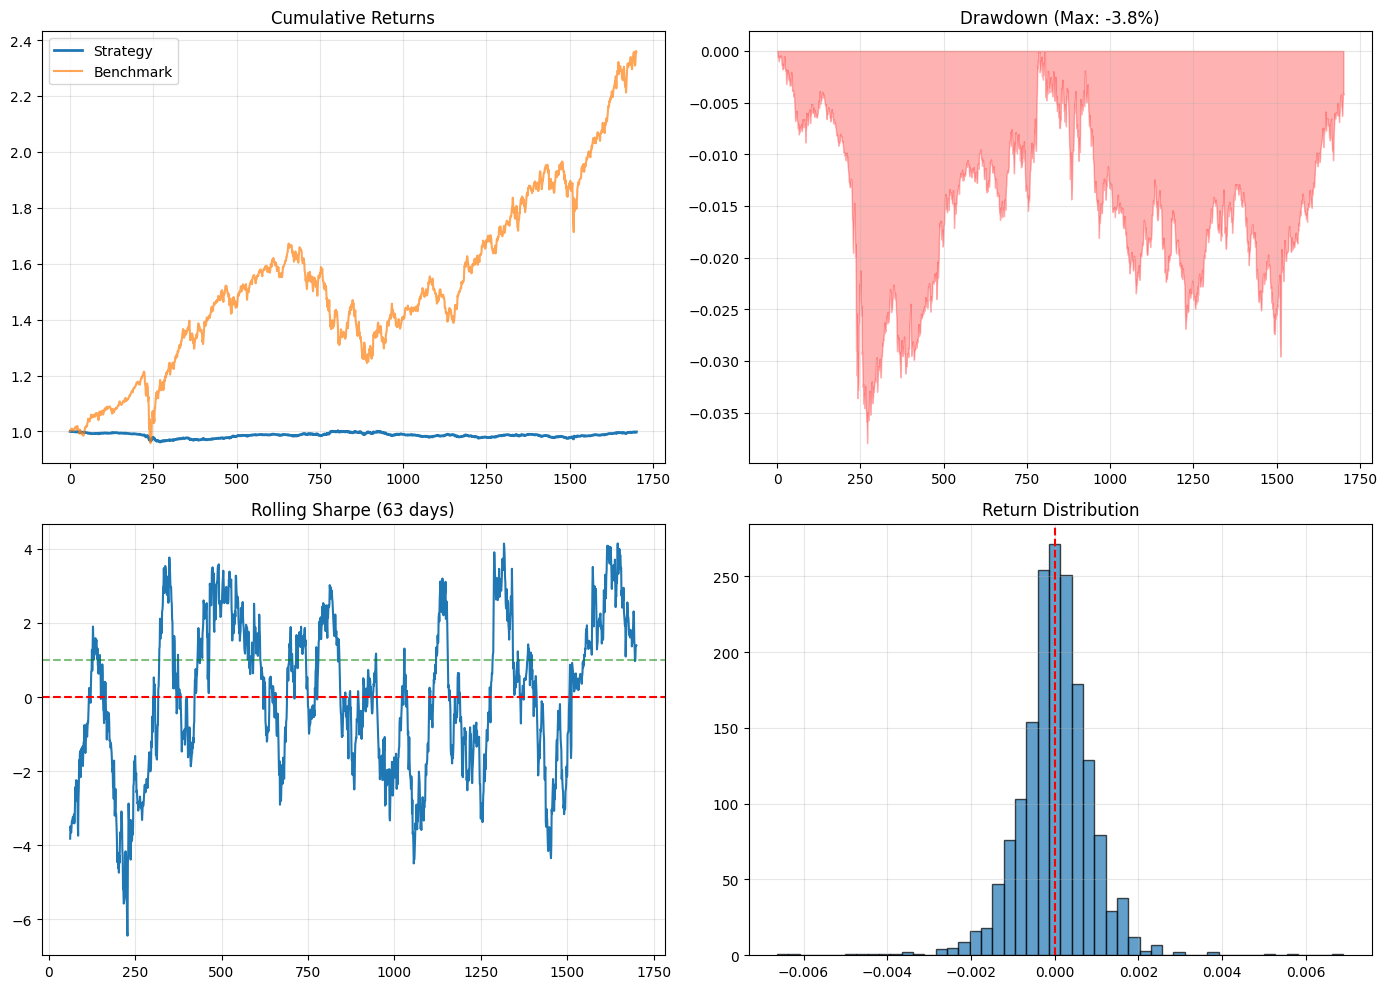

In [7]:
class BacktestPipeline:
    """
    Complete end-to-end backtesting pipeline
    """
    
    def __init__(self, config: BacktestConfig):
        self.config = config
        
    def run(self, tickers: List[str], start_date: str,
            model_class, model_params: Dict = None,
            signal_method: str = 'sign') -> Dict:
        """
        Run complete backtest pipeline
        """
        print("\n" + "=" * 70)
        print("              BACKTEST PIPELINE")
        print("=" * 70)
        
        # 1. Load and prepare data
        print("\n📊 STEP 1: DATA LOADING")
        data = DataModule(tickers, start_date)
        data.load_data()
        data.engineer_features()
        data.create_targets(horizon=1)
        
        # 2. Train model with walk-forward
        print("\n🤖 STEP 2: MODEL TRAINING")
        model = ModelModule(model_class, model_params or {})
        results = model.walk_forward_predict(
            data.features.values,
            data.target.values,
            self.config.train_window,
            self.config.test_window,
            self.config.embargo_days
        )
        
        # 3. Generate signals
        print("\n📈 STEP 3: SIGNAL GENERATION")
        strategy = StrategyModule(results['predictions'], self.config)
        strategy.generate_signals(method=signal_method)
        strategy.calculate_positions()
        strategy.calculate_turnover()
        
        # 4. Simulate execution
        print("\n💰 STEP 4: EXECUTION SIMULATION")
        execution = ExecutionModule(self.config)
        exec_results = execution.calculate_returns(
            strategy.positions,
            results['actuals']
        )
        
        # 5. Analyze performance
        print("\n📊 STEP 5: PERFORMANCE ANALYSIS")
        analytics = AnalyticsModule(
            exec_results['net_returns'],
            results['actuals']
        )
        
        print(analytics.generate_report())
        analytics.plot_performance()
        
        return {
            'data': data,
            'model': model,
            'strategy': strategy,
            'execution': execution,
            'analytics': analytics
        }

# Run complete pipeline
pipeline = BacktestPipeline(config)
results = pipeline.run(
    tickers=['SPY', 'QQQ', 'IWM', 'TLT', 'GLD'],
    start_date='2018-01-01',
    model_class=Ridge,
    model_params={'alpha': 1.0},
    signal_method='sign'
)

## 8. ⏱️ TIMED CODING CHALLENGE (30 minutes)

**Challenge:** Extend the pipeline to support:
1. Multiple models comparison
2. Parameter optimization
3. Monte Carlo simulation for confidence intervals

In [8]:
# YOUR CODE HERE

## 9. Key Takeaways

| Component | Purpose |
|-----------|---------|
| DataModule | Load, clean, feature engineering |
| ModelModule | Walk-forward training & prediction |
| StrategyModule | Signal generation & position sizing |
| ExecutionModule | Cost modeling & returns calculation |
| AnalyticsModule | Performance metrics & reporting |

---

**Tomorrow:** Interview Review & Practice